In [1]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Importar funcion de seleccion de features
from package_ml.modeling.selection import get_permutation_importance

2025-06-21 12:52:10.614 | INFO     | package_ml.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/azure_ml


In [2]:
DATA_PATH = Path('../data/interim/train_fe.parquet')
df = pd.read_parquet(DATA_PATH)

In [3]:
TARGET = "Calories"
FEATURES = [col for col in df.columns if col not in [TARGET, "User_ID"]]

In [4]:
y = df[TARGET]
X = df[FEATURES]

In [6]:
importance_df = get_permutation_importance(X, y)

# Mostrar las características con importancia positiva
print("\n--- Ranking de Importancia de Características (solo con impacto positivo) ---")
important_features_ranked = importance_df[importance_df['importance_mean'] > 0]
important_features_ranked

División de datos: 12000 para entrenar, 3000 para validar.
Entrenando modelo base para la evaluación de características...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 63
[LightGBM] [Info] Start training from score 4.156507
Calculando importancias en el set de validación...
--- Cálculo de Permutación de Importancia completado ---

--- Ranking de Importancia de Características (solo con impacto positivo) ---


,feature,importance_mean,importance_std
62,feno_var,75.778697,0.501866
0,Gender,9.748085,0.164963
21,Heart_Rate_x_Body_Temp,5.558383,0.090126
52,Percent_FCMT_tanaka,4.564507,0.060135
19,Duration_x_Heart_Rate,3.211647,0.039781
18,Weight_x_Body_Temp,1.409978,0.026634
3,Weight,1.172924,0.023543
29,Age_x_Duration_x_Heart_Rate,0.972944,0.023208
12,Height_x_Weight,0.661206,0.018742
34,Height_x_Weight_x_Body_Temp,0.251514,0.007220


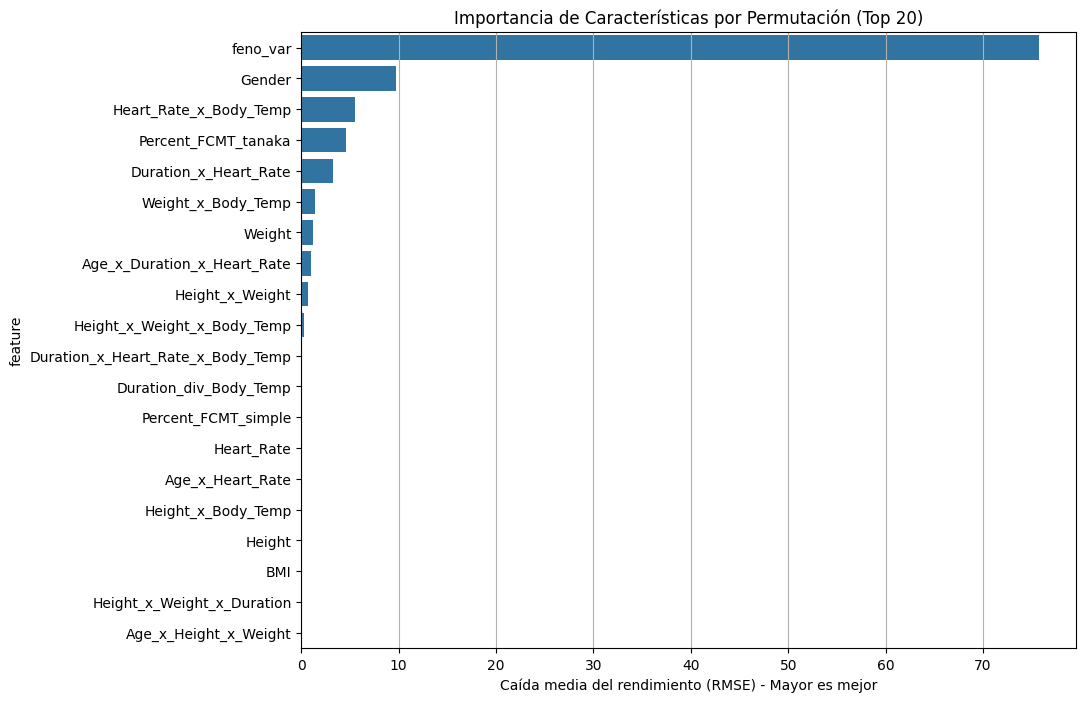

In [7]:
# Visualizar las más importantes para ayudar en la decisión
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance_mean', 
    y='feature', 
    data=important_features_ranked.head(20) # Visualizamos las 20 mejores
)
plt.title('Importancia de Características por Permutación (Top 20)')
plt.xlabel('Caída media del rendimiento (RMSE) - Mayor es mejor')
plt.grid(axis='x')
plt.show()

In [8]:
# Definimos manualmente las que tienen mas sentido
final_selected_features = [
    'feno_var',
    'Gender',
    'Heart_Rate_x_Body_Temp',
    'Percent_FCMT_tanaka',
    'Duration_x_Heart_Rate',
    'Weight_x_Body_Temp',
    'Weight',
    'Height',
    'Age'
]

In [9]:
# Filtrar el DataFrame X para las siguientes etapas
X_selected = X[final_selected_features]

# Guardar esta lista para reproducibilidad y para las siguientes etapas
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)
features_path = MODELS_DIR / 'final_features.json'

with open(features_path, 'w') as f:
    json.dump(final_selected_features, f)

print(f"\nLista de características finales guardada en: {features_path}")


Lista de características finales guardada en: ../models/final_features.json


## Optimizacion de hiperparametros

In [5]:
from package_ml.modeling.train import optimize_lgbm_hyperparameters
import json
from pathlib import Path

/home/fernando/Documentos/azure_ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Cargar las características seleccionadas previamente
with open('../models/final_features.json', 'r') as f:
    final_selected_features = json.load(f)

# Filtrar el DataFrame X
X_selected = X[final_selected_features]

In [7]:
X_selected.head()

,feno_var,Gender,Heart_Rate_x_Body_Temp,Percent_FCMT_tanaka,Duration_x_Heart_Rate,Weight_x_Body_Temp,Weight,Height,Age
0,1262.9616,True,4284.0,65.461347,3045.0,3835.2,94.0,190.0,68.0
1,429.6964,False,3788.2,48.453608,1316.0,2418.0,60.0,166.0,20.0
2,150.2240,True,3405.6,55.103319,440.0,3057.3,79.0,179.0,69.0
3,465.4143,False,4050.0,54.288817,1300.0,2875.5,71.0,179.0,34.0
4,251.4440,False,3223.8,42.834479,810.0,2308.4,58.0,154.0,27.0


In [8]:
study = optimize_lgbm_hyperparameters(
    X=X_selected,
    y=y,
    stratify_on=df['Gender'],
    n_trials=30,
    cv_splits=5
)

[I 2025-06-21 12:52:18,409] A new study created in memory with name: calories_lgbm


Iniciando estudio de Optuna bajo la ejecución principal de MLflow: 7cce91a0c89f4e489a061a338ce08201


[I 2025-06-21 12:52:21,375] Trial 0 finished with value: 22.349219518028434 and parameters: {'n_estimators': 1606, 'learning_rate': 0.0010144061504296605, 'num_leaves': 441, 'max_depth': 5, 'min_child_samples': 32, 'subsample': 0.6198826638880489, 'colsample_bytree': 0.6983640578883248, 'lambda_l1': 0.2374747881220768, 'lambda_l2': 1.5686153609146034}. Best is trial 0 with value: 22.349219518028434.
[I 2025-06-21 12:52:25,334] Trial 1 finished with value: 1.8347547560865578 and parameters: {'n_estimators': 2733, 'learning_rate': 0.004344943587146399, 'num_leaves': 166, 'max_depth': 4, 'min_child_samples': 82, 'subsample': 0.9669407754527157, 'colsample_bytree': 0.5954795414868453, 'lambda_l1': 0.0037117122393891355, 'lambda_l2': 0.013957620150754324}. Best is trial 1 with value: 1.8347547560865578.
[I 2025-06-21 12:52:29,897] Trial 2 finished with value: 2.3119504188626196 and parameters: {'n_estimators': 2769, 'learning_rate': 0.003283916443793739, 'num_leaves': 429, 'max_depth': 6, '

Optimización completada. Registrando los mejores resultados.


In [9]:
print("▶ Best RMSE:", study.best_value)
print("▶ Best params:", study.best_params)

▶ Best RMSE: 0.9364699350642299
▶ Best params: {'n_estimators': 3382, 'learning_rate': 0.011676038706474223, 'num_leaves': 391, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.7025772562186442, 'colsample_bytree': 0.6468238117765404, 'lambda_l1': 3.8239841238809933, 'lambda_l2': 0.08509071007217121}


In [10]:
# Guardar los mejores parámetros en un archivo para la etapa final
MODELS_DIR = Path('../models')
best_params_path = MODELS_DIR / 'best_lgbm_params.json'

with open(best_params_path, 'w') as f:
    json.dump(study.best_params, f)